In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU

Using TensorFlow backend.


In [2]:
data_train = pd.read_csv('air_quality_train.csv')
data_test = pd.read_csv('air_quality_test.csv')

In [3]:
data_train.drop('Unnamed: 0', axis=1, inplace=True)
data_test.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
def series_to_supervised(data, in_lag=1, out_lag=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(in_lag, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, out_lag):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    new_df = pd.concat(cols, axis=1)
    new_df.columns = names
    
    if dropnan:
        new_df.dropna(inplace=True)
    return new_df

# lag = 1

In [5]:
data_train_framed = series_to_supervised(data_train)

In [6]:
data_train_framed.drop(data_train_framed.columns[[12,13,14,15,16,17,18,19,20,21,22]], axis=1, inplace=True)

In [7]:
x = data_train_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)'
]]

y = data_train_framed.loc[:,['var12(t)']]

In [8]:
data_test_framed = series_to_supervised(data_test)

In [9]:
data_test_framed.drop(data_test_framed.columns[[12,13,14,15,16,17,18,19,20,21,22]], axis=1, inplace=True)

In [10]:
x_validation = data_test_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)'
]]

y_validation = data_test_framed.loc[:,['var12(t)']]

In [11]:
def split_data(x, y, train_size):
    x_train = x[:int(len(x)*train_size)]
    x_test = x[int(len(x)*train_size):]
    y_train = y[:int(len(y)*train_size)]
    y_test = y[int(len(y)*train_size):]
    
    return x_train, x_test, y_train, y_test

In [12]:
x_train, x_test, y_train, y_test = split_data(x, y, train_size=0.8)

In [13]:
x = np.expand_dims(x, axis=2)
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [14]:
x_validation = np.expand_dims(x_validation, axis=2)

In [15]:
print(x.shape, x_train.shape, x_test.shape, x_validation.shape)

(7483, 12, 1) (5986, 12, 1) (1497, 12, 1) (1871, 12, 1)


In [16]:
stop_noimprovement = EarlyStopping(patience=10)

model = Sequential()

model.add(LSTM(50, input_shape=(12, 1), dropout=0.2))
model.add(Dense(1))

model.compile(loss="mae", optimizer="adam")

W0710 05:14:28.300397 140486806853248 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 05:14:28.324171 140486806853248 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 05:14:28.328353 140486806853248 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0710 05:14:28.539602 140486806853248 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_w

# Test and validation with 100 epochs

In [18]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

W0710 04:54:17.337851 139952400262784 deprecation.py:323] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0710 04:54:18.298083 139952400262784 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 5986 samples, validate on 1497 samples
Epoch 1/100
 - 4s - loss: 0.1337 - val_loss: 0.1706
Epoch 2/100
 - 3s - loss: 0.1189 - val_loss: 0.2045
Epoch 3/100
 - 3s - loss: 0.1117 - val_loss: 0.2104
Epoch 4/100
 - 3s - loss: 0.1071 - val_loss: 0.2037
Epoch 5/100
 - 3s - loss: 0.0991 - val_loss: 0.1652
Epoch 6/100
 - 3s - loss: 0.0925 - val_loss: 0.1482
Epoch 7/100
 - 3s - loss: 0.0855 - val_loss: 0.1217
Epoch 8/100
 - 3s - loss: 0.0795 - val_loss: 0.1009
Epoch 9/100
 - 3s - loss: 0.0721 - val_loss: 0.0819
Epoch 10/100
 - 3s - loss: 0.0651 - val_loss: 0.0767
Epoch 11/100
 - 3s - loss: 0.0592 - val_loss: 0.0632
Epoch 12/100
 - 3s - loss: 0.0523 - val_loss: 0.0653
Epoch 13/100
 - 3s - loss: 0.0453 - val_loss: 0.0685
Epoch 14/100
 - 3s - loss: 0.0420 - val_loss: 0.0675
Epoch 15/100
 - 3s - loss: 0.0395 - val_loss: 0.0640
Epoch 16/100
 - 3s - loss: 0.0388 - val_loss: 0.0674
Epoch 17/100
 - 3s - loss: 0.0400 - val_loss: 0.0661
Epoch 18/100
 - 3s - loss: 0.0387 - val_loss: 0.0768
Epoch 1

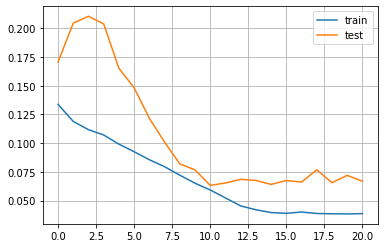

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
prediction = model.predict(x_test)

In [21]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.07503


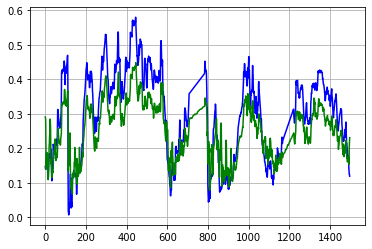

In [22]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [23]:
validation = model.predict(x_validation)

In [24]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.07692


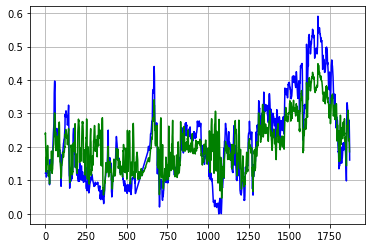

In [25]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test and validation with 500 epochs

In [26]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=500,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 5986 samples, validate on 1497 samples
Epoch 1/500
 - 3s - loss: 0.0368 - val_loss: 0.0648
Epoch 2/500
 - 3s - loss: 0.0386 - val_loss: 0.0719
Epoch 3/500
 - 3s - loss: 0.0386 - val_loss: 0.0674
Epoch 4/500
 - 3s - loss: 0.0377 - val_loss: 0.0691
Epoch 5/500
 - 3s - loss: 0.0374 - val_loss: 0.0642
Epoch 6/500
 - 3s - loss: 0.0367 - val_loss: 0.0653
Epoch 7/500
 - 3s - loss: 0.0375 - val_loss: 0.0588
Epoch 8/500
 - 3s - loss: 0.0380 - val_loss: 0.0645
Epoch 9/500
 - 3s - loss: 0.0370 - val_loss: 0.0700
Epoch 10/500
 - 3s - loss: 0.0370 - val_loss: 0.0702
Epoch 11/500
 - 3s - loss: 0.0367 - val_loss: 0.0681
Epoch 12/500
 - 3s - loss: 0.0363 - val_loss: 0.0698
Epoch 13/500
 - 3s - loss: 0.0364 - val_loss: 0.0644
Epoch 14/500
 - 3s - loss: 0.0356 - val_loss: 0.0748
Epoch 15/500
 - 3s - loss: 0.0350 - val_loss: 0.0626
Epoch 16/500
 - 3s - loss: 0.0329 - val_loss: 0.0695
Epoch 17/500
 - 3s - loss: 0.0331 - val_loss: 0.0641


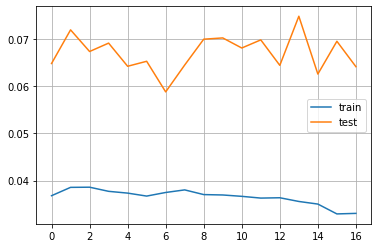

In [27]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
prediction = model.predict(x_test)

In [29]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.07217


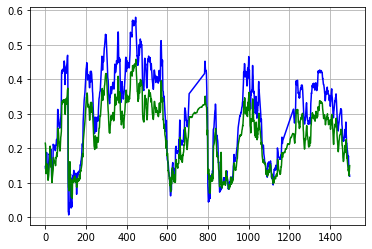

In [30]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [31]:
validation = model.predict(x_validation)

In [32]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.05896


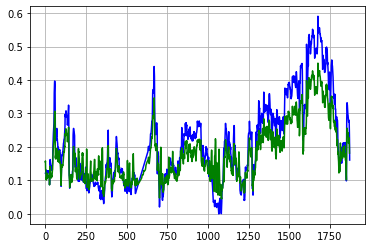

In [33]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# Test and validation with 1000 epochs

In [34]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=1000,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 5986 samples, validate on 1497 samples
Epoch 1/1000
 - 3s - loss: 0.0329 - val_loss: 0.0601
Epoch 2/1000
 - 3s - loss: 0.0319 - val_loss: 0.0724
Epoch 3/1000
 - 3s - loss: 0.0332 - val_loss: 0.0686
Epoch 4/1000
 - 3s - loss: 0.0319 - val_loss: 0.0686
Epoch 5/1000
 - 3s - loss: 0.0315 - val_loss: 0.0675
Epoch 6/1000
 - 3s - loss: 0.0309 - val_loss: 0.0592
Epoch 7/1000
 - 3s - loss: 0.0316 - val_loss: 0.0601
Epoch 8/1000
 - 3s - loss: 0.0308 - val_loss: 0.0618
Epoch 9/1000
 - 3s - loss: 0.0315 - val_loss: 0.0659
Epoch 10/1000
 - 3s - loss: 0.0297 - val_loss: 0.0640
Epoch 11/1000
 - 3s - loss: 0.0298 - val_loss: 0.0634
Epoch 12/1000
 - 3s - loss: 0.0290 - val_loss: 0.0642
Epoch 13/1000
 - 3s - loss: 0.0289 - val_loss: 0.0642
Epoch 14/1000
 - 3s - loss: 0.0278 - val_loss: 0.0644
Epoch 15/1000
 - 3s - loss: 0.0265 - val_loss: 0.0598
Epoch 16/1000
 - 3s - loss: 0.0258 - val_loss: 0.0665


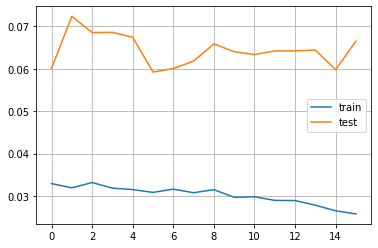

In [35]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
prediction = model.predict(x_test)

In [37]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.07415


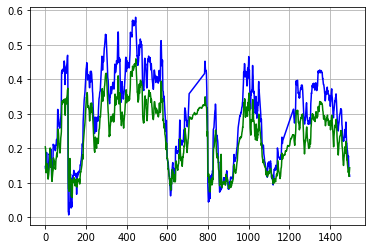

In [38]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [39]:
validation = model.predict(x_validation)

In [40]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.06019


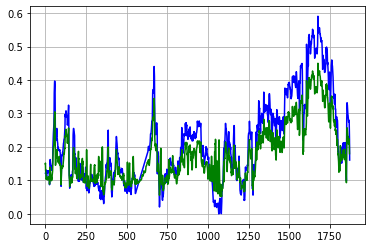

In [41]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# lag = 5

In [36]:
data_train_framed = series_to_supervised(data_train, out_lag=5)

In [37]:
len(data_train_framed.columns)

72

In [38]:
data_train_framed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       'var11(t-1)', 'var12(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)',
       'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)',
       'var11(t)', 'var12(t)', 'var1(t+1)', 'var2(t+1)', 'var3(t+1)',
       'var4(t+1)', 'var5(t+1)', 'var6(t+1)', 'var7(t+1)', 'var8(t+1)',
       'var9(t+1)', 'var10(t+1)', 'var11(t+1)', 'var12(t+1)', 'var1(t+2)',
       'var2(t+2)', 'var3(t+2)', 'var4(t+2)', 'var5(t+2)', 'var6(t+2)',
       'var7(t+2)', 'var8(t+2)', 'var9(t+2)', 'var10(t+2)', 'var11(t+2)',
       'var12(t+2)', 'var1(t+3)', 'var2(t+3)', 'var3(t+3)', 'var4(t+3)',
       'var5(t+3)', 'var6(t+3)', 'var7(t+3)', 'var8(t+3)', 'var9(t+3)',
       'var10(t+3)', 'var11(t+3)', 'var12(t+3)', 'var1(t+4)', 'var2(t+4)',
       'var3(t+4)', 'var4(t+4)', 'var5(t+4)', 'var6(t+4)', 'var7(t+4)',
       'var8(t+4)', 'var9(t+4)', 'var10(t+4)', 

In [39]:
data_train_framed.drop(data_train_framed.columns[[
    12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,
    32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,
    52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
]], axis=1, inplace=True)

In [40]:
data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var12(t+4)
1,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,0.499371,0.280066,0.293261
2,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,0.484277,0.264282,0.281288
3,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,0.563522,0.276352,0.286126
4,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,0.638994,0.294190,0.283487
5,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,0.633962,0.295216,0.277085


In [41]:
x = data_train_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)'
]]

y = data_train_framed.loc[:,['var12(t+4)']]

In [42]:
x_train, x_test, y_train, y_test = split_data(x, y, train_size=0.8)

In [43]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [44]:
data_test_framed = series_to_supervised(data=data_test, out_lag=5)

In [45]:
data_test_framed.drop(data_test_framed.columns[[
    12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,
    32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,
    52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
]], axis=1, inplace=True)

data_test_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var12(t+4)
1,0.059322,0.123475,0.028302,0.105407,0.075829,0.347310,0.245562,0.116007,0.117724,0.286022,0.286792,0.120364,0.116356
2,0.050847,0.133525,0.029874,0.109776,0.071090,0.348158,0.230769,0.121403,0.105126,0.283871,0.293082,0.121536,0.110101
3,0.084746,0.165111,0.042453,0.141453,0.117806,0.302838,0.325444,0.138489,0.149435,0.277419,0.299371,0.121390,0.110394
4,0.084746,0.175879,0.050314,0.155653,0.120515,0.294367,0.352071,0.144335,0.178540,0.262366,0.324528,0.123638,0.114646
5,0.093220,0.180905,0.051887,0.158930,0.142180,0.288014,0.384615,0.153777,0.204170,0.221505,0.398742,0.131701,0.113962


In [46]:
x_validation = data_test_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)'
]]

y_validation = data_test_framed.loc[:,['var12(t+4)']]

In [47]:
x_validation = np.expand_dims(x_validation, axis=2)

# Test and validation with 100 epochs

In [48]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 5983 samples, validate on 1496 samples
Epoch 1/100
 - 3s - loss: 0.0635 - val_loss: 0.0793
Epoch 2/100
 - 3s - loss: 0.0624 - val_loss: 0.0742
Epoch 3/100
 - 3s - loss: 0.0628 - val_loss: 0.0776
Epoch 4/100
 - 3s - loss: 0.0626 - val_loss: 0.0757
Epoch 5/100
 - 3s - loss: 0.0619 - val_loss: 0.0750
Epoch 6/100
 - 3s - loss: 0.0616 - val_loss: 0.0757
Epoch 7/100
 - 4s - loss: 0.0609 - val_loss: 0.0756
Epoch 8/100
 - 3s - loss: 0.0616 - val_loss: 0.0762
Epoch 9/100
 - 3s - loss: 0.0595 - val_loss: 0.0785
Epoch 10/100
 - 3s - loss: 0.0598 - val_loss: 0.0741
Epoch 11/100
 - 3s - loss: 0.0594 - val_loss: 0.0763
Epoch 12/100
 - 3s - loss: 0.0580 - val_loss: 0.0769
Epoch 13/100
 - 3s - loss: 0.0578 - val_loss: 0.0734
Epoch 14/100
 - 3s - loss: 0.0574 - val_loss: 0.0710
Epoch 15/100
 - 3s - loss: 0.0563 - val_loss: 0.0714
Epoch 16/100
 - 3s - loss: 0.0567 - val_loss: 0.0709
Epoch 17/100
 - 3s - loss: 0.0549 - val_loss: 0.0746
Epoch 18/100
 - 3s - loss: 0.0557 - val_loss: 0.0684
Epoch 1

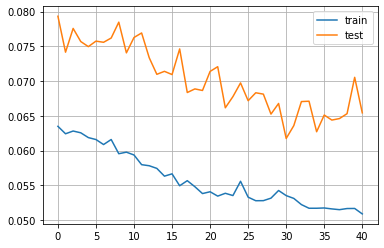

In [49]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
prediction = model.predict(x_test)

In [51]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.07838


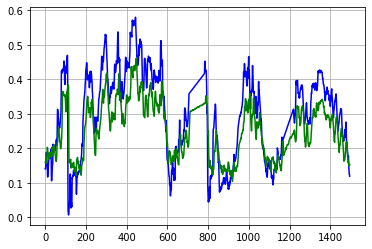

In [52]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [53]:
validation = model.predict(x_validation)

In [54]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.06223


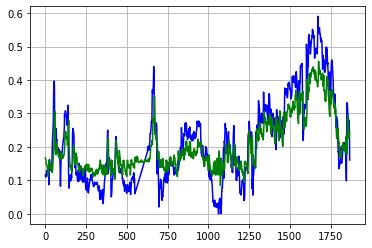

In [55]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# 500 epochs

In [56]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=500,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 5983 samples, validate on 1496 samples
Epoch 1/500
 - 3s - loss: 0.0506 - val_loss: 0.0631
Epoch 2/500
 - 3s - loss: 0.0510 - val_loss: 0.0646
Epoch 3/500
 - 3s - loss: 0.0512 - val_loss: 0.0650
Epoch 4/500
 - 3s - loss: 0.0509 - val_loss: 0.0624
Epoch 5/500
 - 3s - loss: 0.0510 - val_loss: 0.0645
Epoch 6/500
 - 3s - loss: 0.0515 - val_loss: 0.0623
Epoch 7/500
 - 3s - loss: 0.0506 - val_loss: 0.0598
Epoch 8/500
 - 3s - loss: 0.0506 - val_loss: 0.0639
Epoch 9/500
 - 3s - loss: 0.0512 - val_loss: 0.0662
Epoch 10/500
 - 3s - loss: 0.0502 - val_loss: 0.0625
Epoch 11/500
 - 3s - loss: 0.0509 - val_loss: 0.0644
Epoch 12/500
 - 3s - loss: 0.0512 - val_loss: 0.0632
Epoch 13/500
 - 3s - loss: 0.0504 - val_loss: 0.0623
Epoch 14/500
 - 3s - loss: 0.0508 - val_loss: 0.0634
Epoch 15/500
 - 3s - loss: 0.0512 - val_loss: 0.0640
Epoch 16/500
 - 3s - loss: 0.0510 - val_loss: 0.0625
Epoch 17/500
 - 3s - loss: 0.0500 - val_loss: 0.0618


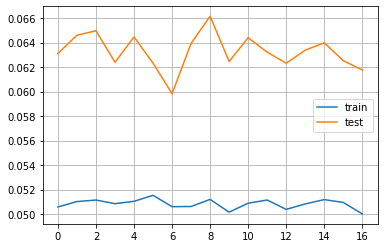

In [57]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
prediction = model.predict(x_test)

In [59]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.07482


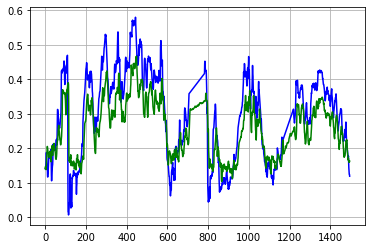

In [60]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [61]:
validation = model.predict(x_validation)

In [62]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.06072


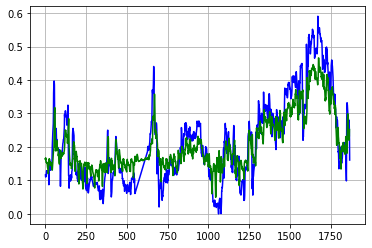

In [63]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# 1000 epochs

In [64]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=1000,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 5983 samples, validate on 1496 samples
Epoch 1/1000
 - 3s - loss: 0.0513 - val_loss: 0.0631
Epoch 2/1000
 - 3s - loss: 0.0512 - val_loss: 0.0636
Epoch 3/1000
 - 3s - loss: 0.0512 - val_loss: 0.0582
Epoch 4/1000
 - 3s - loss: 0.0507 - val_loss: 0.0586
Epoch 5/1000
 - 3s - loss: 0.0508 - val_loss: 0.0617
Epoch 6/1000
 - 3s - loss: 0.0503 - val_loss: 0.0615
Epoch 7/1000
 - 3s - loss: 0.0501 - val_loss: 0.0615
Epoch 8/1000
 - 3s - loss: 0.0501 - val_loss: 0.0587
Epoch 9/1000
 - 3s - loss: 0.0501 - val_loss: 0.0615
Epoch 10/1000
 - 3s - loss: 0.0499 - val_loss: 0.0608
Epoch 11/1000
 - 3s - loss: 0.0503 - val_loss: 0.0612
Epoch 12/1000
 - 3s - loss: 0.0500 - val_loss: 0.0600
Epoch 13/1000
 - 3s - loss: 0.0499 - val_loss: 0.0605


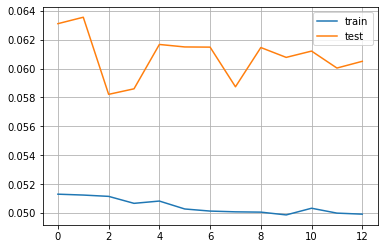

In [65]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
prediction = model.predict(x_test)

In [67]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.07355


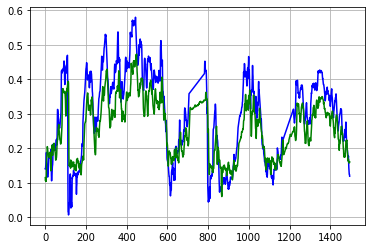

In [68]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [69]:
validation = model.predict(x_validation)

In [70]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.05923


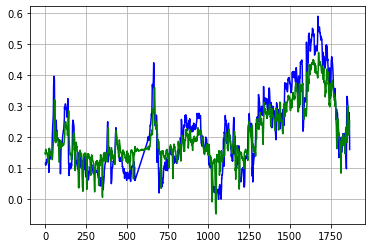

In [71]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# lag = 10

In [72]:
data_train_framed = series_to_supervised(data_train, out_lag=10)

In [73]:
data_train_framed.drop(data_train_framed.columns[[
    12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,
    32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,
    52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,
    72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,
    92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,
    109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,
    124,125,126,127,128,129,130
]], axis=1, inplace=True)
data_train_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var12(t+9)
1,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,0.499371,0.280066,0.274544
2,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,0.484277,0.264282,0.269706
3,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,0.563522,0.276352,0.269071
4,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,0.638994,0.294190,0.272199
5,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,0.633962,0.295216,0.271759


In [74]:
x = data_train_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)'
]]

y = data_train_framed.loc[:,['var12(t+9)']]

In [75]:
x_train, x_test, y_train, y_test = split_data(x, y, train_size=0.8)

In [76]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [77]:
data_test_framed = series_to_supervised(data_test, out_lag=10)

In [78]:
data_test_framed.drop(data_test_framed.columns[[
    12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,
    32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,
    52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,
    72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,
    92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,
    109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,
    124,125,126,127,128,129,130
]], axis=1, inplace=True)
data_test_framed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var12(t+9)
1,0.059322,0.123475,0.028302,0.105407,0.075829,0.347310,0.245562,0.116007,0.117724,0.286022,0.286792,0.120364,0.118898
2,0.050847,0.133525,0.029874,0.109776,0.071090,0.348158,0.230769,0.121403,0.105126,0.283871,0.293082,0.121536,0.122269
3,0.084746,0.165111,0.042453,0.141453,0.117806,0.302838,0.325444,0.138489,0.149435,0.277419,0.299371,0.121390,0.128867
4,0.084746,0.175879,0.050314,0.155653,0.120515,0.294367,0.352071,0.144335,0.178540,0.262366,0.324528,0.123638,0.127401
5,0.093220,0.180905,0.051887,0.158930,0.142180,0.288014,0.384615,0.153777,0.204170,0.221505,0.398742,0.131701,0.129111


In [79]:
x_validation = data_test_framed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)'
]]

y_validation = data_test_framed.loc[:,['var12(t+9)']]

In [80]:
x_validation = np.expand_dims(x_validation, axis=2)

# 100 epochs

In [81]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 5979 samples, validate on 1495 samples
Epoch 1/100
 - 3s - loss: 0.0622 - val_loss: 0.0651
Epoch 2/100
 - 3s - loss: 0.0629 - val_loss: 0.0647
Epoch 3/100
 - 3s - loss: 0.0628 - val_loss: 0.0646
Epoch 4/100
 - 3s - loss: 0.0622 - val_loss: 0.0654
Epoch 5/100
 - 3s - loss: 0.0620 - val_loss: 0.0641
Epoch 6/100
 - 3s - loss: 0.0623 - val_loss: 0.0639
Epoch 7/100
 - 3s - loss: 0.0627 - val_loss: 0.0651
Epoch 8/100
 - 3s - loss: 0.0614 - val_loss: 0.0637
Epoch 9/100
 - 3s - loss: 0.0617 - val_loss: 0.0652
Epoch 10/100
 - 3s - loss: 0.0626 - val_loss: 0.0647
Epoch 11/100
 - 3s - loss: 0.0619 - val_loss: 0.0621
Epoch 12/100
 - 3s - loss: 0.0620 - val_loss: 0.0628
Epoch 13/100
 - 3s - loss: 0.0623 - val_loss: 0.0627
Epoch 14/100
 - 3s - loss: 0.0621 - val_loss: 0.0642
Epoch 15/100
 - 3s - loss: 0.0620 - val_loss: 0.0642
Epoch 16/100
 - 3s - loss: 0.0620 - val_loss: 0.0638
Epoch 17/100
 - 3s - loss: 0.0615 - val_loss: 0.0646
Epoch 18/100
 - 3s - loss: 0.0623 - val_loss: 0.0635
Epoch 1

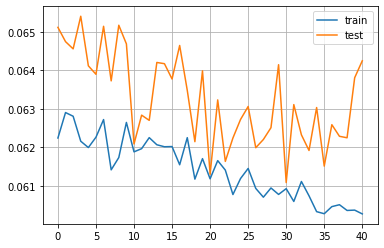

In [82]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
prediction = model.predict(x_test)

In [84]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.08288


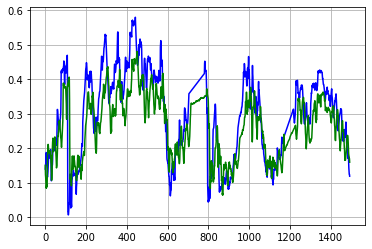

In [85]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [86]:
validation = model.predict(x_validation)

In [87]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.05787


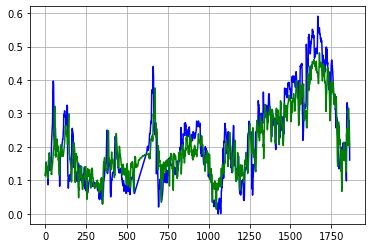

In [88]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# 500 epochs

In [89]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=500,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 5979 samples, validate on 1495 samples
Epoch 1/500
 - 3s - loss: 0.0605 - val_loss: 0.0615
Epoch 2/500
 - 3s - loss: 0.0608 - val_loss: 0.0635
Epoch 3/500
 - 3s - loss: 0.0603 - val_loss: 0.0619
Epoch 4/500
 - 3s - loss: 0.0607 - val_loss: 0.0617
Epoch 5/500
 - 3s - loss: 0.0604 - val_loss: 0.0625
Epoch 6/500
 - 3s - loss: 0.0604 - val_loss: 0.0610
Epoch 7/500
 - 3s - loss: 0.0607 - val_loss: 0.0628
Epoch 8/500
 - 3s - loss: 0.0603 - val_loss: 0.0604
Epoch 9/500
 - 3s - loss: 0.0602 - val_loss: 0.0615
Epoch 10/500
 - 3s - loss: 0.0602 - val_loss: 0.0637
Epoch 11/500
 - 3s - loss: 0.0605 - val_loss: 0.0614
Epoch 12/500
 - 3s - loss: 0.0607 - val_loss: 0.0604
Epoch 13/500
 - 3s - loss: 0.0601 - val_loss: 0.0606
Epoch 14/500
 - 3s - loss: 0.0601 - val_loss: 0.0602
Epoch 15/500
 - 3s - loss: 0.0600 - val_loss: 0.0618
Epoch 16/500
 - 3s - loss: 0.0599 - val_loss: 0.0626
Epoch 17/500
 - 3s - loss: 0.0601 - val_loss: 0.0604
Epoch 18/500
 - 3s - loss: 0.0601 - val_loss: 0.0624
Epoch 1

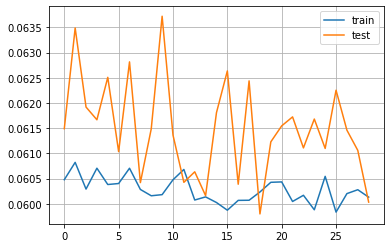

In [90]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [91]:
prediction = model.predict(x_test)

In [92]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.07843


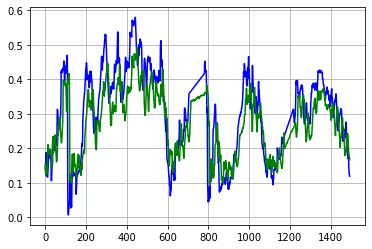

In [93]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [94]:
validation = model.predict(x_validation)

In [95]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.05606


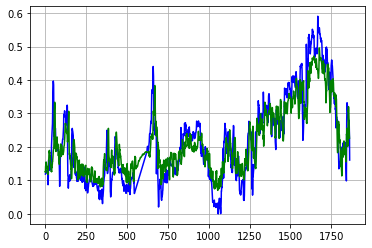

In [96]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)

# 1000 epochs

In [97]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=1000,
    verbose=2,
    callbacks=[stop_noimprovement],
    shuffle=False
)

Train on 5979 samples, validate on 1495 samples
Epoch 1/1000
 - 3s - loss: 0.0601 - val_loss: 0.0608
Epoch 2/1000
 - 3s - loss: 0.0602 - val_loss: 0.0600
Epoch 3/1000
 - 3s - loss: 0.0601 - val_loss: 0.0612
Epoch 4/1000
 - 3s - loss: 0.0602 - val_loss: 0.0605
Epoch 5/1000
 - 3s - loss: 0.0602 - val_loss: 0.0613
Epoch 6/1000
 - 3s - loss: 0.0600 - val_loss: 0.0624
Epoch 7/1000
 - 3s - loss: 0.0604 - val_loss: 0.0617
Epoch 8/1000
 - 3s - loss: 0.0601 - val_loss: 0.0606
Epoch 9/1000
 - 3s - loss: 0.0604 - val_loss: 0.0618
Epoch 10/1000
 - 3s - loss: 0.0603 - val_loss: 0.0610
Epoch 11/1000
 - 3s - loss: 0.0602 - val_loss: 0.0618
Epoch 12/1000
 - 3s - loss: 0.0603 - val_loss: 0.0610


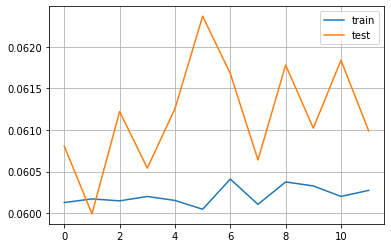

In [98]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
prediction = model.predict(x_test)

In [100]:
print('Test:')
print(np.sqrt(mean_squared_error(y_test, prediction)).round(5))

Test:
0.07939


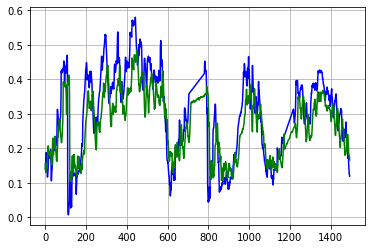

In [101]:
plt.plot(y_test.reset_index(drop=True), 'b')
plt.plot(prediction, 'g')
plt.grid(True)

In [102]:
validation = model.predict(x_validation)

In [103]:
print('Validation:')
print(np.sqrt(mean_squared_error(y_validation, validation)).round(5))

Validation:
0.05742


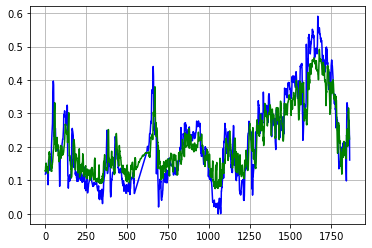

In [104]:
plt.plot(y_validation, 'b')
plt.plot(validation, 'g')
plt.grid(True)